In [31]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [32]:
FIGSIZE = (20, 6)

location = "A101"
idx = "datetime"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"treated-data/by_day_rolling_{location}.csv")
by_day_rolling.tail()

,datetime,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
7695,2024-07-27,476.621429,0.088393,68.361607,29.784226,28.704464,1.377827,3.832589
7696,2024-07-28,484.957440,0.088393,68.081845,29.802083,28.742708,1.412351,3.895833
7697,2024-07-29,489.300893,0.088393,67.665179,29.846577,28.797619,1.440327,3.952083
7698,2024-07-30,492.486161,0.088393,67.212798,29.903869,28.858482,1.439732,3.946131
7699,2024-07-31,500.735261,0.088095,66.473150,30.018705,28.974224,1.456166,3.951100


In [33]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,476.621429,0.088393,68.361607,29.784226,28.704464,1.377827,3.832589
2024-07-28,484.957440,0.088393,68.081845,29.802083,28.742708,1.412351,3.895833
2024-07-29,489.300893,0.088393,67.665179,29.846577,28.797619,1.440327,3.952083
2024-07-30,492.486161,0.088393,67.212798,29.903869,28.858482,1.439732,3.946131
2024-07-31,500.735261,0.088095,66.473150,30.018705,28.974224,1.456166,3.951100


(6910, 365)

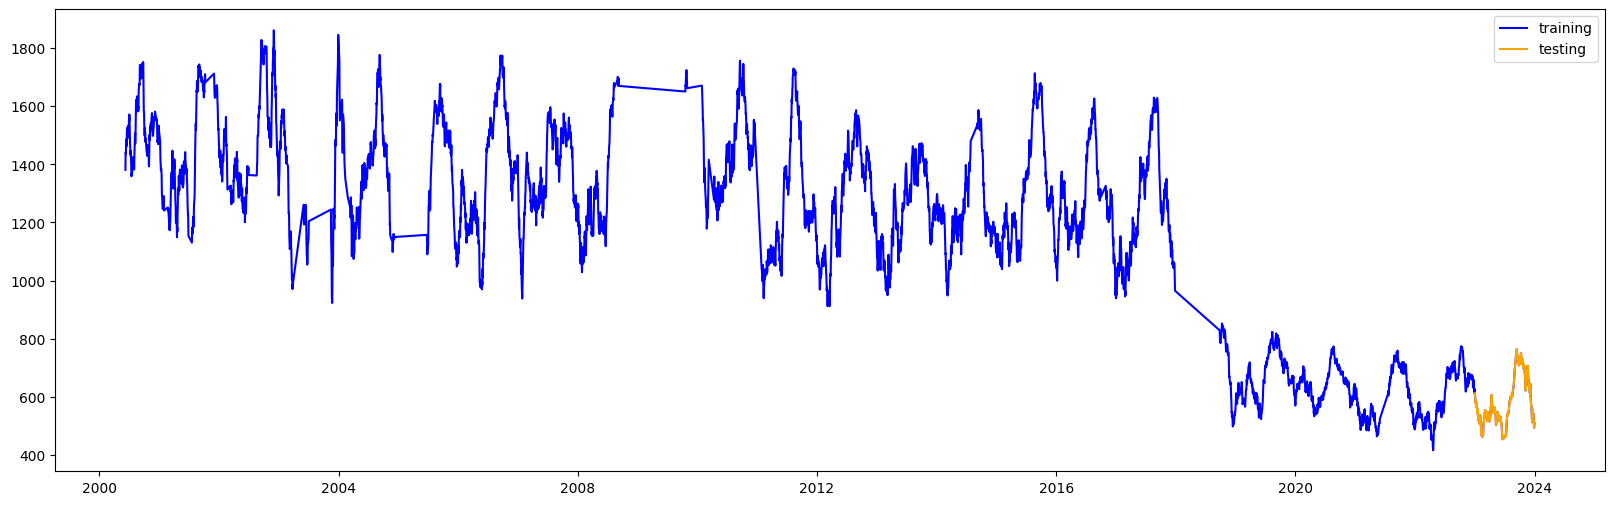

In [34]:
from src.train_test_data import split_datasets

date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)

train_rolling, test_rolling = split_datasets(
    by_day_rolling, date_threshold, date_upper_threshold
)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

len(train_rolling), len(test_rolling)

In [35]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

reg = Prophet()
reg.fit(fit_data)

11:43:06 - cmdstanpy - INFO - Chain [1] start processing
11:43:07 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)

future.tail()

,ds
9460,2030-12-26
9461,2030-12-27
9462,2030-12-28
9463,2030-12-29
9464,2030-12-30


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


'plotting prophet forecast:'

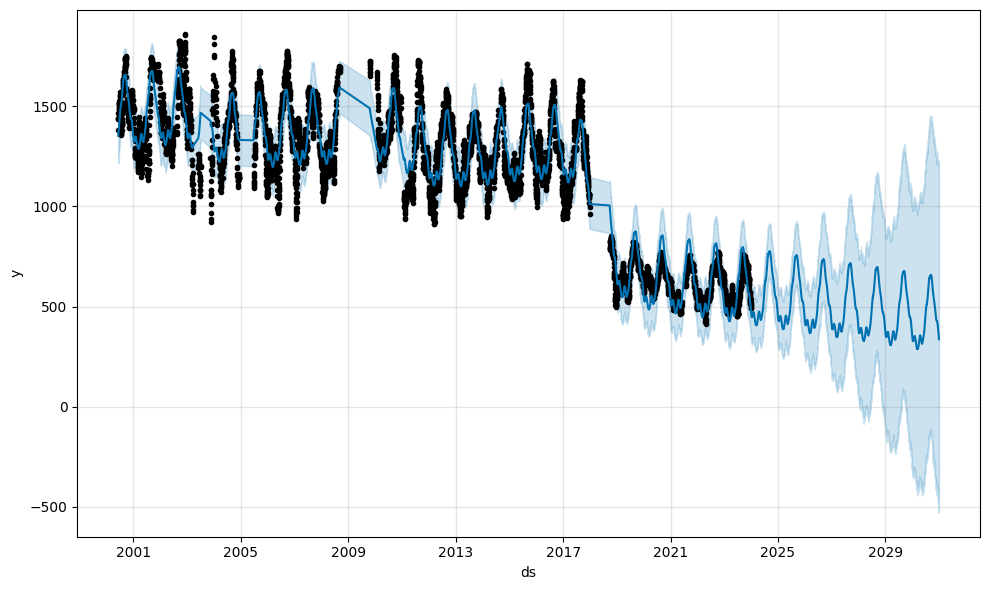

In [37]:
forecast = reg.predict(future)
reg.plot(forecast)
"plotting prophet forecast:"

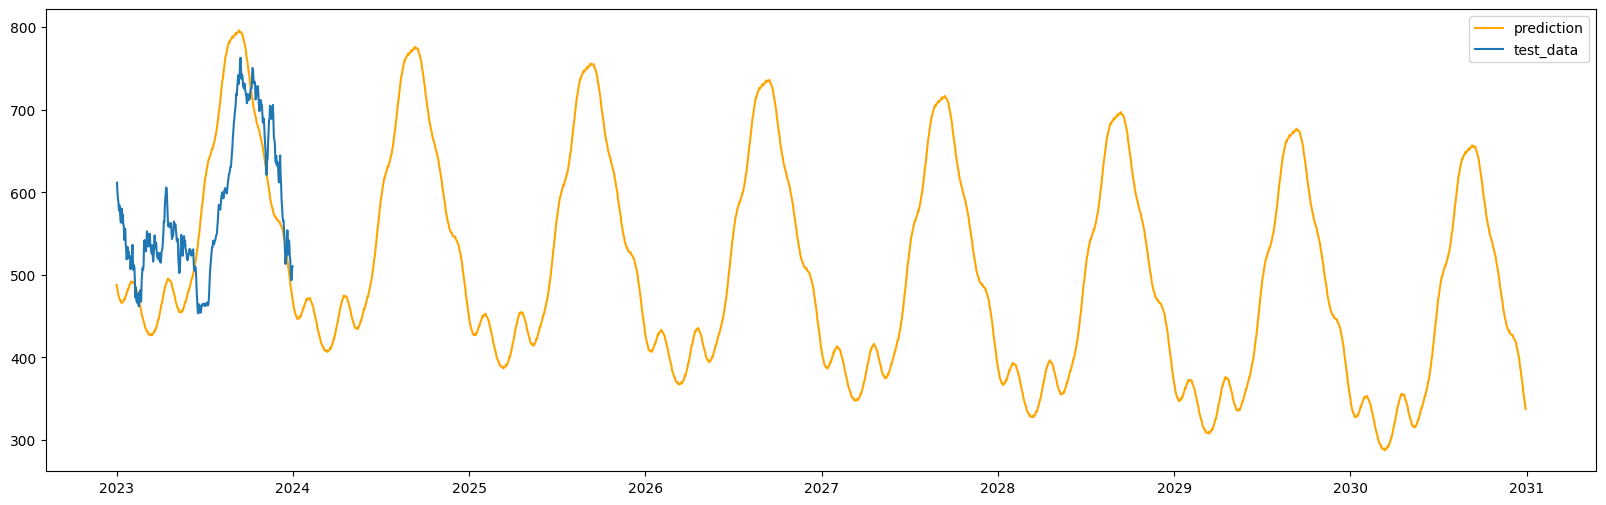

In [38]:
prediction = forecast.loc[forecast.ds >= date_threshold, ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.1316%'

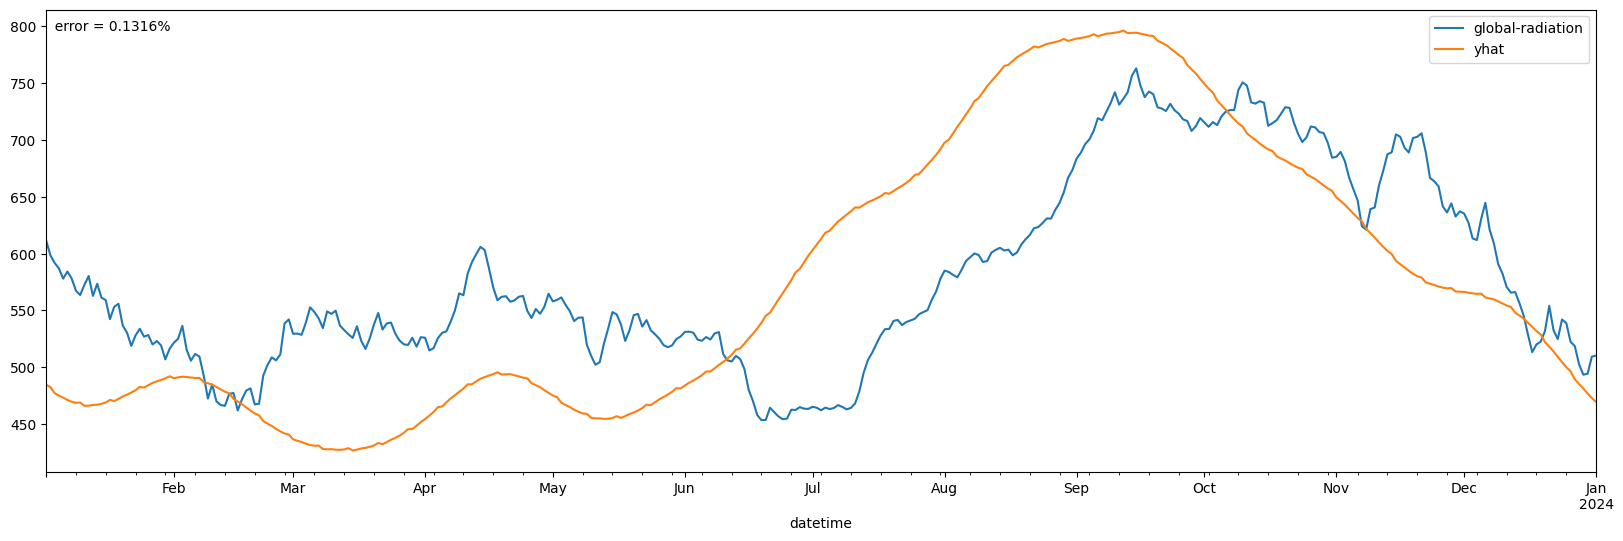

In [63]:
from src.train_test_data import testing_treshold


prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat}).loc[
    testing_treshold(prediction.ds, date_threshold, date_upper_threshold)
]
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[
    (comparison.yhat.notna()) & (comparison[target].notna()), [idx, target, "yhat"]
].set_index(idx)
comparison
error = mape(comparison[target], comparison.yhat)
ax = comparison.plot(figsize=FIGSIZE)
ax.text(comparison.index.min(), comparison.max(None), f"  error = {error:.4f}%")
f"predition error is {error:.4f}%"